# Deep Learning : Recurrent Neural Networks imdb

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [0]:
import numpy as np
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras import Model
from keras import backend as K

colab = True
student = True

Using TensorFlow backend.


## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zerp-pad each sequence a length ```max_review_length````

In [0]:
top_words = 5000 
max_review_length = 100
INDEX_FROM = 3

## Import IMDB data

In [0]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
if colab==False:
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
else:
    """
    # --- IF USING GOOGLE.COLAB
    # --- save np.load
    np_load_old = np.load
    # --- modify the default parameters of np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    # --- call load_data with allow_pickle implicitly set to true
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)
    # --- restore np.load for future normal usage
    np.load = np_load_old
    """
    np.load.__defaults__=(None, True, True, 'ASCII')
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
    np.load.__defaults__=(None, False, True, 'ASCII')

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [0]:
print(y_train[0])

1


## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

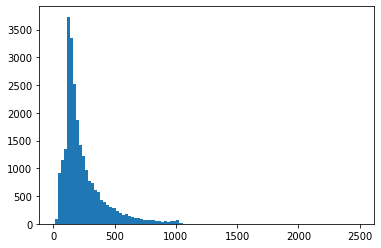

In [0]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [0]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

1646592/1641221 [==============================] - 0s 0us/step
<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a brig

In [0]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [0]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [0]:
# --- truncate and pad input sequences

if student:
    X_train = sequence.pad_sequences(
        X_train,
        maxlen=max_review_length,
        dtype='int32',
        padding='pre',
        truncating='pre',
        value=0.0
    )
    X_test = sequence.pad_sequences(
        X_test,
        maxlen=max_review_length,
        dtype='int32',
        padding='pre',
        truncating='pre',
        value=0.0
    )

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117    2   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
    2   18    4  226   22   21  134  476   26  480    5  144   30    2
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16    2   19
  178   32]


# First model

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [1]:
K.clear_session()

In [0]:
# --- create the model
embedding_vector_length = 32

# CODE-RNN1-2
if student:
    # --- Using the Sequential API
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length, name="emb1"))
    model.add(Lambda(lambda x: K.mean(x, axis=1)))
    model.add(Dense(1, activation="sigmoid"))

    # The model with funcitonal API is separately writen and trained in the blocks below. 

print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb1 (Embedding)             (None, 100, 32)           160000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None


In [2]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

In [0]:
# CODE-RNN1-2
if student:                      
    # --- Using the Functional API
    x = Input((max_review_length,))
    emb = Embedding(top_words, embedding_vector_length, input_length=max_review_length, name="emb2")(x)
    ave = Lambda(lambda x: K.mean(x, axis=1))(emb)
    y = Dense(1, activation="sigmoid")(ave)
    model_functional = Model(inputs=x, outputs=y)

print(model_functional.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
emb2 (Embedding)             (None, 100, 32)           160000    
_________________________________________________________________
lambda_2 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# --- compile and fit the model
model_functional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_functional.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 103us/step - loss: 0.6422 - acc: 0.7025 - val_loss: 0.5670 - val_acc: 0.7691
Epoch 2/10
25000/25000 [==============================] - 2s 90us/step - loss: 0.4895 - acc: 0.8115 - val_loss: 0.4419 - val_acc: 0.8206
Epoch 3/10
25000/25000 [==============================] - 2s 89us/step - loss: 0.3954 - acc: 0.8457 - val_loss: 0.3860 - val_acc: 0.8358
Epoch 4/10
25000/25000 [==============================] - 2s 86us/step - loss: 0.3484 - acc: 0.8584 - val_loss: 0.3595 - val_acc: 0.8436
Epoch 5/10
25000/25000 [==============================] - 2s 83us/step - loss: 0.3200 - acc: 0.8694 - val_loss: 0.3469 - val_acc: 0.8474
Epoch 6/10
25000/25000 [==============================] - 2s 90us/step - loss: 0.3002 - acc: 0.8775 - val_loss: 0.3383 - val_acc: 0.8510
Epoch 7/10
25000/25000 [==============================] - 3s 102us/step - loss: 0.2856 - acc: 0.8838 - val_loss: 0.3346 - val_a

## Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

In [0]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.39%


In [0]:
# --- Final evaluation of the model
scores_functional = model_functional.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_functional[1]*100))

Accuracy: 85.46%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [0]:
if student:
    E = model.get_layer('emb1').get_weights()[0]   
    target = E[word_to_id['great']]
    dis = [np.linalg.norm(target-v) for v in E]
    closest = np.argsort(dis)[1]
    print(id_to_word[closest])

outstanding


# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=100$

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [0]:
K.clear_session()

In [0]:
# --- create the model

if student:
    # --- Using the Sequential API
    n_a = 100
    model_lstm = Sequential()
    model_lstm.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length, name="emb1"))
    model_lstm.add(LSTM(n_a))
    model_lstm.add(Dense(1, activation="sigmoid"))
    
    # The model with funcitonal API is separately writen and trained in the blocks below. 
    
print(model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb1 (Embedding)             (None, 100, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# --- compile and fit the model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 69s 3ms/step - loss: 0.4348 - acc: 0.7894 - val_loss: 0.3457 - val_acc: 0.8476
Epoch 2/3
25000/25000 [==============================] - 69s 3ms/step - loss: 0.3042 - acc: 0.8736 - val_loss: 0.3559 - val_acc: 0.8428
Epoch 3/3
25000/25000 [==============================] - 69s 3ms/step - loss: 0.2657 - acc: 0.8925 - val_loss: 0.3623 - val_acc: 0.8376


In [0]:
# --- create the model

if student:
    n_a = 100
    # --- Using the Functional API
    x = Input((max_review_length,))
    emb = Embedding(top_words, embedding_vector_length, input_length=max_review_length, name="emb4")(x)
    lstm = LSTM(n_a)(emb)
    y = Dense(1, activation="sigmoid")(lstm)
    model_lstm_functional = Model(inputs=x, outputs=y)
   


print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb1 (Embedding)             (None, 100, 32)           160000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# --- compile and fit the model
model_lstm_functional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_functional.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 68s 3ms/step - loss: 0.4413 - acc: 0.7857 - val_loss: 0.3479 - val_acc: 0.8482
Epoch 2/3
25000/25000 [==============================] - 68s 3ms/step - loss: 0.3049 - acc: 0.8748 - val_loss: 0.3539 - val_acc: 0.8427
Epoch 3/3
25000/25000 [==============================] - 68s 3ms/step - loss: 0.2730 - acc: 0.8905 - val_loss: 0.3706 - val_acc: 0.8410


## Results

In [0]:
# --- Final evaluation of the model
scores_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100)) 

Accuracy: 85.39%


In [0]:
# --- Final evaluation of the model
scores_lstm_functional = model_lstm_functional.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100)) 

Accuracy: 85.39%
